# Feature Importance & Ablation Study: Wine Quality Dataset

**Research Question:** "Which features matter and why? An ablation study on the Wine Quality dataset."

**Author:** Katrin Nguyen & Nico Loss
**Semester:** Winter 2025  
**Instructor:** Prof. Dr. Sigurd Schacht

## 1. Setup & Imports <a id='setup'></a>

In [138]:
# Standard libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings

# Scikit-learn imports
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    classification_report, confusion_matrix
)

# Feature selection methods
from sklearn.feature_selection import (
    mutual_info_classif,
    RFE,
    SelectKBest,
    f_classif
)
from sklearn.inspection import permutation_importance

# Report generation
from ydata_profiling import ProfileReport

# For data fetching
from ucimlrepo import fetch_ucirepo

warnings.filterwarnings('ignore')

# Set random seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Configuration
TEST_SIZE = 0.20
CV_FOLDS = 5

Path("Reports").mkdir(exist_ok=True)
Path("figures").mkdir(exist_ok=True)

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✓ All imports successful")
print(f"✓ Random seed set to {RANDOM_STATE}")
print(f"✓ Figures directory: {FIGURES_DIR.absolute()}")

✓ All imports successful
✓ Random seed set to 42
✓ Figures directory: D:\Master KDT\Semester 1\Angew KI\WorkspaceKDT\Papers\Paper2\figures


## 2. Data Loading & Exploration <a id='data-loading'></a>

### 2.1 Load Dataset
Link: https://archive.ics.uci.edu/dataset/186/wine+quality

In [139]:
# Fetch dataset from UCI repository
print("Fetching Wine Quality dataset from UCI repository...")
wine_quality = fetch_ucirepo(id=186)

# Extract features and target
X = wine_quality.data.features
y = wine_quality.data.targets

# Combine for easier manipulation
df = pd.concat([X, y], axis=1)

print(f"\n✓ Dataset loaded successfully")
print(f"  - Shape: {df.shape}")
print(f"  - Features: {X.shape[1]}")
print(f"  - Samples: {len(df)}")

print("\n" + "="*50)
print("DATASET METADATA")
print("="*50)
print(wine_quality.metadata)

print("\n" + "="*50)
print("VARIABLE INFORMATION")
print("="*50)
print(wine_quality.variables)

Fetching Wine Quality dataset from UCI repository...

✓ Dataset loaded successfully
  - Shape: (6497, 12)
  - Features: 11
  - Samples: 6497

DATASET METADATA
{'uci_id': 186, 'name': 'Wine Quality', 'repository_url': 'https://archive.ics.uci.edu/dataset/186/wine+quality', 'data_url': 'https://archive.ics.uci.edu/static/public/186/data.csv', 'abstract': 'Two datasets are included, related to red and white vinho verde wine samples, from the north of Portugal. The goal is to model wine quality based on physicochemical tests (see [Cortez et al., 2009], http://www3.dsi.uminho.pt/pcortez/wine/).', 'area': 'Business', 'tasks': ['Classification', 'Regression'], 'characteristics': ['Multivariate'], 'num_instances': 4898, 'num_features': 11, 'feature_types': ['Real'], 'demographics': [], 'target_col': ['quality'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2009, 'last_updated': 'Wed Nov 15 2023', 'dataset_doi': '10.24432/C56S3T', 'cr

## 3. Data Preprocessing <a id='preprocessing'></a>

### 3.1 Missing Values Check

In [140]:
print("Missing Values:")
missing = df.isnull().sum()
print(missing[missing > 0] if missing.sum() > 0 else "No missing values")
print("\n✓ Dataset is clean - no missing values")

Missing Values:
No missing values

✓ Dataset is clean - no missing values


### 3.2 Train/Validation/Test Split

In [141]:
print("\n" + "="*50)
print("TRAIN-VALIDATION-TEST SPLIT (BEFORE PREPROCESSING)")
print("="*50)

# First split: separate test set (20%)
df_temp, df_test = train_test_split(df, test_size=0.2, random_state=42)

# Second split: separate train (60%) and validation (20% of total = 25% of temp)
df_train, df_val = train_test_split(df_temp, test_size=0.25, random_state=42)

print(f"Training set (raw): {len(df_train)} samples")
print(f"Validation set (raw): {len(df_val)} samples")
print(f"Test set (raw): {len(df_test)} samples")


TRAIN-VALIDATION-TEST SPLIT (BEFORE PREPROCESSING)
Training set (raw): 3897 samples
Validation set (raw): 1300 samples
Test set (raw): 1300 samples


### 3.3 Prepare Feature and Target

In [142]:
print("\n" + "="*50)
print("FEATURE AND TARGET PREPARATION")
print("="*50)

# Zielvariable (Target)
TARGET_COL = 'quality'

# Extract features and targets
X_train = df_train.drop(TARGET_COL, axis=1)
y_train = df_train['quality']

X_val = df_val.drop(TARGET_COL, axis=1)
y_val = df_val['quality']

X_test = df_test.drop(TARGET_COL, axis=1)
y_test = df_test['quality']

print(f"X_train shape: {X_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"X_test shape: {X_test.shape}")


FEATURE AND TARGET PREPARATION
X_train shape: (3897, 11)
X_val shape: (1300, 11)
X_test shape: (1300, 11)


### 3.4 Feature Scaling

In [143]:
scaler = StandardScaler()

X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train),
    columns=X_train.columns,
    index=X_train.index
)

X_val_scaled = pd.DataFrame(
    scaler.transform(X_val),
    columns=X_val.columns,
    index=X_val.index
)

X_test_scaled = pd.DataFrame(
    scaler.transform(X_test),
    columns=X_test.columns,
    index=X_test.index
)

print("Feature Scaling Complete (StandardScaler)")
print(f"  Train mean: {X_train_scaled.mean().mean():.6f}")
print(f"  Train std:  {X_train_scaled.std().mean():.6f}")
print("\n✓ Fitted on training set only (no data leakage)")

Feature Scaling Complete (StandardScaler)
  Train mean: -0.000000
  Train std:  1.000128

✓ Fitted on training set only (no data leakage)


## 4.0 Explorative Data Analysis

In [144]:
print("First 5 rows:")
display(df_train.head())

print("\nDataset Statistics:")
display(df_train.describe())

print("\nData Types and Missing Values:")
info_df = pd.DataFrame({
    'Column': df_train.columns,
    'Type': df_train.dtypes,
    'Non-Null': df_train.count(),
    'Null': df_train.isnull().sum(),
    'Null %': (df_train.isnull().sum() / len(df_train) * 100).round(2)
})
display(info_df)

First 5 rows:


,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
5130,6.4,0.28,0.44,7.1,0.048,49.0,179.0,0.99528,3.15,0.48,9.2,5
3064,7.0,0.20,0.74,0.8,0.044,19.0,163.0,0.99310,3.46,0.53,10.2,5
4040,7.2,0.20,0.28,1.6,0.028,13.0,168.0,0.99203,3.17,1.06,11.5,6
363,12.5,0.46,0.63,2.0,0.071,6.0,15.0,0.99880,2.99,0.87,10.2,5
2950,6.5,0.37,0.33,3.9,0.027,40.0,130.0,0.99060,3.28,0.39,12.7,7



Dataset Statistics:


,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
count,3897.000000,3897.000000,3897.000000,3897.000000,3897.000000,3897.000000,3897.000000,3897.000000,3897.000000,3897.000000,3897.000000,3897.000000
mean,7.202386,0.333989,0.322153,5.439505,0.055677,30.615602,115.989736,0.994682,3.216633,0.531309,10.477577,5.810880
std,1.275064,0.159433,0.143929,4.816520,0.035309,17.303389,55.695568,0.003029,0.157320,0.148621,1.186415,0.866561
min,3.900000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.740000,0.220000,8.000000,3.000000
25%,6.400000,0.220000,0.250000,1.800000,0.038000,17.000000,79.000000,0.992300,3.110000,0.430000,9.500000,5.000000
50%,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994860,3.210000,0.510000,10.300000,6.000000
75%,7.700000,0.400000,0.390000,8.100000,0.064000,41.000000,156.000000,0.996920,3.320000,0.600000,11.300000,6.000000
max,15.600000,1.580000,1.000000,65.800000,0.611000,131.000000,344.000000,1.038980,3.900000,2.000000,14.200000,9.000000



Data Types and Missing Values:


,Column,Type,Non-Null,Null,Null %
fixed_acidity,fixed_acidity,float64,3897,0,0.0
volatile_acidity,volatile_acidity,float64,3897,0,0.0
citric_acid,citric_acid,float64,3897,0,0.0
residual_sugar,residual_sugar,float64,3897,0,0.0
chlorides,chlorides,float64,3897,0,0.0
free_sulfur_dioxide,free_sulfur_dioxide,float64,3897,0,0.0
total_sulfur_dioxide,total_sulfur_dioxide,float64,3897,0,0.0
density,density,float64,3897,0,0.0
pH,pH,float64,3897,0,0.0
sulphates,sulphates,float64,3897,0,0.0


### 4.3 Report Generation

In [145]:
profile = ProfileReport(df_train, title="Wine Quality Dataset Report", explorative=True)
profile.to_file("Reports/wine_quality_ydata_profiling.html")

Export report to file: 100%|██████████| 1/1 [00:00<00:00, 38.69it/s]


### 4.4 Correlation Analysis

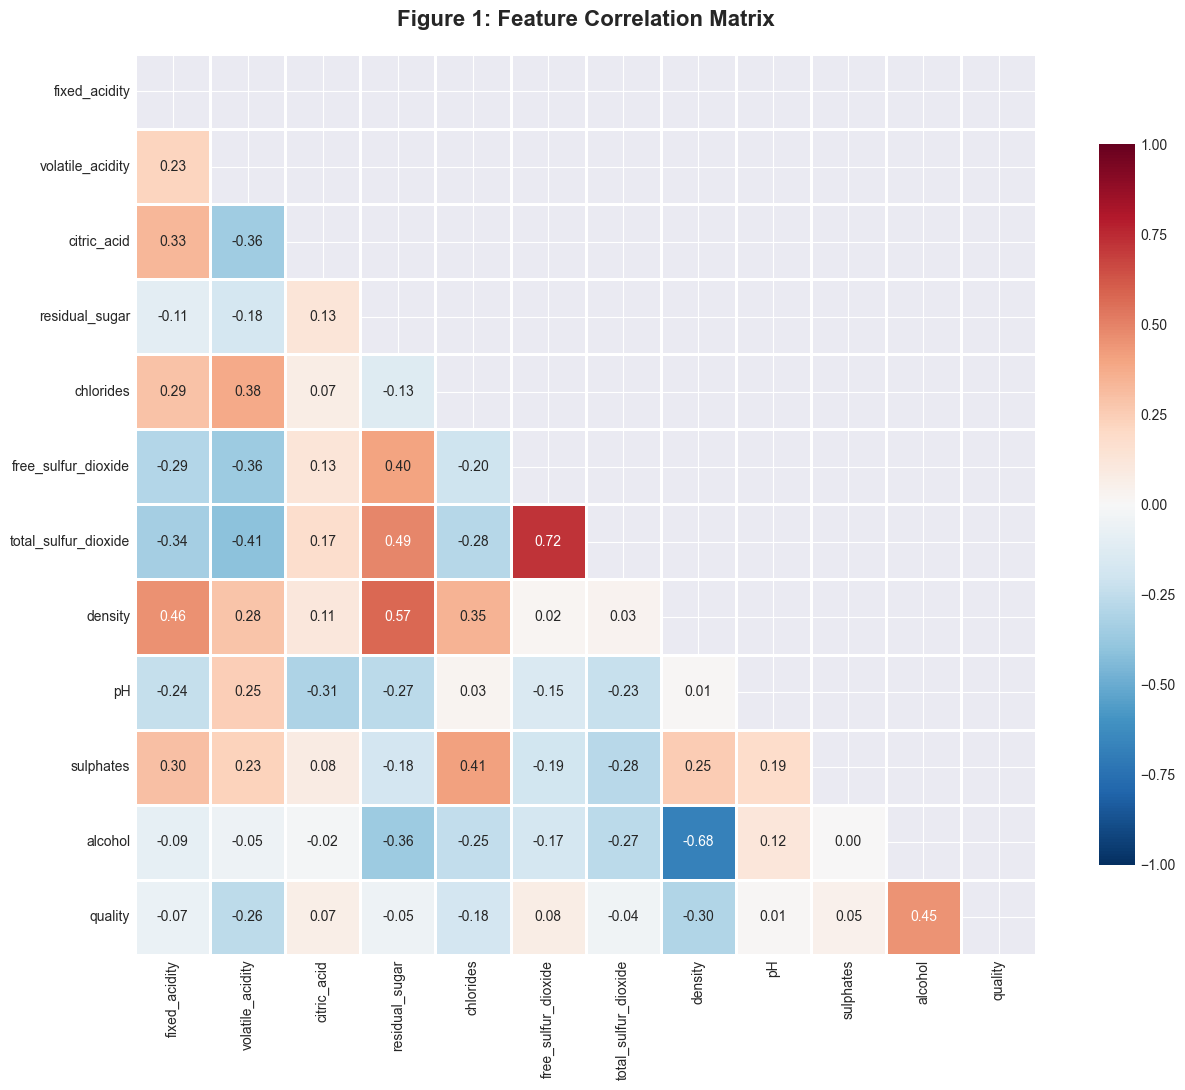


Correlations with Quality:
alcohol                 0.447730
free_sulfur_dioxide     0.075108
citric_acid             0.070005
sulphates               0.048677
pH                      0.014420
total_sulfur_dioxide   -0.040591
residual_sugar         -0.047370
fixed_acidity          -0.069560
chlorides              -0.184246
volatile_acidity       -0.261776
density                -0.303478
Name: quality, dtype: float64


In [146]:
correlation_matrix = df_train.corr()

plt.figure(figsize=(14, 11))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, mask=mask, annot=True, fmt='.2f', cmap='RdBu_r',
            center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8}, vmin=-1, vmax=1)
plt.title('Figure 1: Feature Correlation Matrix', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('figures/figure1_correlation_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nCorrelations with Quality:")
print(correlation_matrix['quality'].drop('quality').sort_values(ascending=False))

## 5. Baseline Model

### 5.1 Train and Evaluate Baseline Model

In [147]:
param_grid = {
    'max_depth': [ 5, 6, 7],
    'min_samples_split': [10, 15, 20, 25],
    'min_samples_leaf': [8, 9, 10],
    'max_features': ['sqrt', 'log2'],
    'n_estimators': [80, 100, 120]
}

rf = RandomForestClassifier(random_state=42, n_jobs=-1)


grid_search = GridSearchCV(estimator=rf, param_grid=param_grid,
                           cv=CV_FOLDS, n_jobs=-1, verbose=2, return_train_score=True)

# 3. Modell trainieren
grid_search.fit(X_train_scaled, y_train)

print(f"\nBeste Parameter nach GridSearchCV: {grid_search.best_params_}")

Fitting 5 folds for each of 216 candidates, totalling 1080 fits

Beste Parameter nach GridSearchCV: {'max_depth': 7, 'max_features': 'sqrt', 'min_samples_leaf': 10, 'min_samples_split': 25, 'n_estimators': 100}


In [148]:
cv_results = pd.DataFrame(grid_search.cv_results_)

# 1. Die Spalten auswählen, die uns interessieren
relevant_cols = [
    'params',
    'mean_train_score',
    'mean_test_score',
    'rank_test_score'
]
# .copy() verhindert eine 'SettingWithCopyWarning'
results_df = cv_results[relevant_cols].copy()

# 2. Den "Gap" (Overfitting) als neue Spalte berechnen
results_df['gap'] = results_df['mean_train_score'] - results_df['mean_test_score']

# 3. Ergebnisse anzeigen
print("\n" + "="*50)
print("Analyse des Train-Test-Gaps (Overfitting)")
print("="*50)

# Zeigt die Top-Performer, aber vielleicht mit hohem Gap
print("\n--- Top 5 Modelle (sortiert nach bestem Test-Score) ---")
print(results_df.sort_values(by='rank_test_score').head())

# Zeigt die Modelle, die am besten generalisieren (kleinstes Overfitting)
print("\n--- Top 5 Modelle (sortiert nach geringstem Gap) ---")
print(results_df.sort_values(by='gap').head())


Analyse des Train-Test-Gaps (Overfitting)

--- Top 5 Modelle (sortiert nach bestem Test-Score) ---
                                                params  mean_train_score  \
214  {'max_depth': 7, 'max_features': 'log2', 'min_...          0.654349   
178  {'max_depth': 7, 'max_features': 'sqrt', 'min_...          0.654349   
184  {'max_depth': 7, 'max_features': 'log2', 'min_...          0.664742   
145  {'max_depth': 7, 'max_features': 'sqrt', 'min_...          0.664742   
148  {'max_depth': 7, 'max_features': 'sqrt', 'min_...          0.664742   

     mean_test_score  rank_test_score       gap  
214         0.577624                1  0.076726  
178         0.577624                1  0.076726  
184         0.576082                3  0.088660  
145         0.576082                3  0.088660  
148         0.576082                3  0.088660  

--- Top 5 Modelle (sortiert nach geringstem Gap) ---
                                               params  mean_train_score  \
21  {'max_dept

In [149]:
baseline_model = RandomForestClassifier(**grid_search.best_params_)
baseline_model.fit(X_train_scaled, y_train)

# Predictions
y_train_pred = baseline_model.predict(X_train_scaled)
y_val_pred = baseline_model.predict(X_val_scaled)
y_test_pred = baseline_model.predict(X_test_scaled)

# Metrics
baseline_metrics = {
    'Training Accuracy': accuracy_score(y_train, y_train_pred),
    'Validation Accuracy': accuracy_score(y_val, y_val_pred),
    'Test Accuracy': accuracy_score(y_test, y_test_pred),
    'Validation F1': f1_score(y_val, y_val_pred, average='weighted'),
    'Validation Precision': precision_score(y_val, y_val_pred, average='weighted', zero_division=0),
    'Validation Recall': recall_score(y_val, y_val_pred, average='weighted'),
    'Test F1': f1_score(y_test, y_test_pred, average='weighted'),
    'Test Precision': precision_score(y_test, y_test_pred, average='weighted', zero_division=0),
    'Test Recall': recall_score(y_test, y_test_pred, average='weighted')
}

# Cross-validation
cv_scores = cross_val_score(baseline_model, X_train_scaled, y_train, 
                            cv=CV_FOLDS, scoring='accuracy')
baseline_metrics['CV Mean'] = cv_scores.mean()
baseline_metrics['CV Std'] = cv_scores.std()

print("\n" + "="*70)
print("TABLE 2: BASELINE PERFORMANCE (REGULARIZED MODEL)")
print("="*70)
for metric, value in baseline_metrics.items():
    print(f"{metric:25s}: {value:.4f}")

# Check overfitting
train_val_gap = baseline_metrics['Training Accuracy'] - baseline_metrics['Validation Accuracy']
print(f"\n{'='*70}")
print(f"OVERFITTING CHECK")
print(f"{'='*70}")
print(f"Train-Validation Gap: {train_val_gap:.4f} ({train_val_gap*100:.2f}%)")

if train_val_gap < 0.05:
    print("✓✓ EXCELLENT: Gap < 5% - No overfitting!")
elif train_val_gap < 0.10:
    print("✓ GOOD: Gap < 10% - Acceptable generalization")
elif train_val_gap < 0.15:
    print("⚠ WARNING: Gap 10-15% - Slight overfitting")
else:
    print("❌ PROBLEM: Gap > 15% - Significant overfitting")

# Save
pd.DataFrame([baseline_metrics]).to_csv('figures/table2_baseline_performance.csv', index=False)
print("\n✓ Saved to figures/table2_baseline_performance.csv")


TABLE 2: BASELINE PERFORMANCE (REGULARIZED MODEL)
Training Accuracy        : 0.6490
Validation Accuracy      : 0.5931
Test Accuracy            : 0.5815
Validation F1            : 0.5519
Validation Precision     : 0.5405
Validation Recall        : 0.5931
Test F1                  : 0.5482
Test Precision           : 0.5488
Test Recall              : 0.5815
CV Mean                  : 0.5740
CV Std                   : 0.0182

OVERFITTING CHECK
Train-Validation Gap: 0.0559 (5.59%)
✓ GOOD: Gap < 10% - Acceptable generalization

✓ Saved to figures/table2_baseline_performance.csv


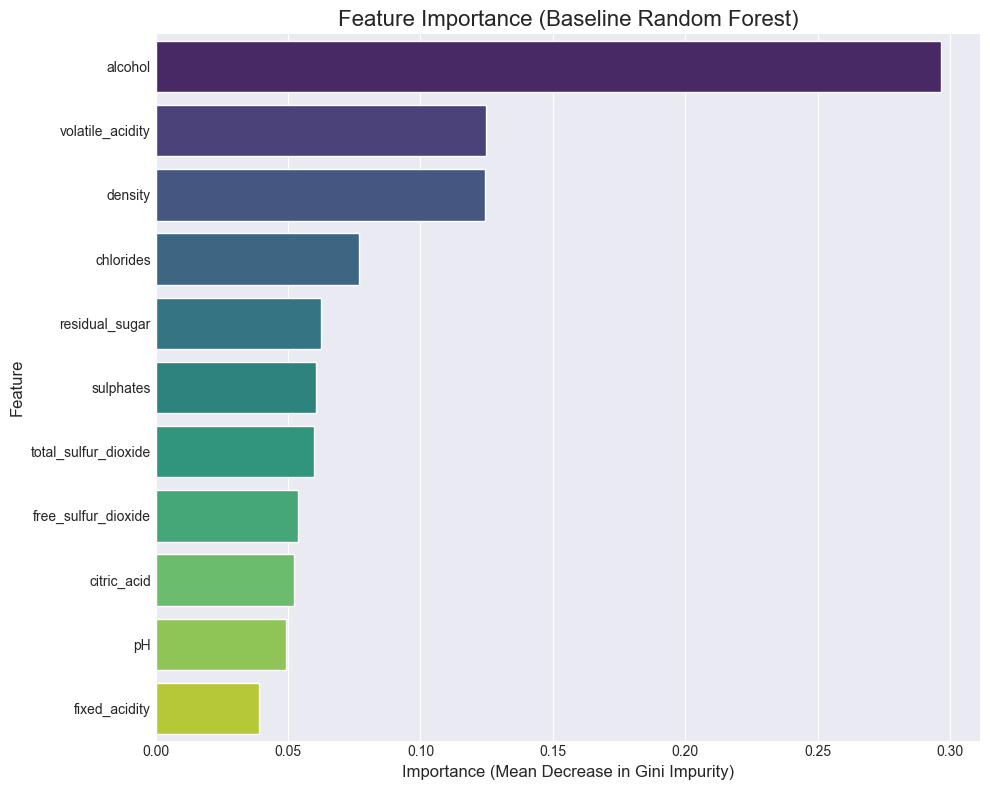


Top 11 Wichtigste Features:
                 Feature  Importance
10               alcohol    0.296491
1       volatile_acidity    0.124729
7                density    0.124515
4              chlorides    0.076970
3         residual_sugar    0.062602
9              sulphates    0.060683
6   total_sulfur_dioxide    0.059851
5    free_sulfur_dioxide    0.053887
2            citric_acid    0.052170
8                     pH    0.049236
0          fixed_acidity    0.038865


In [154]:
# 1. Feature Importance extrahieren
importances = baseline_model.feature_importances_

# 2. Feature-Namen holen
feature_names = X_train.columns

# 3. In einem DataFrame für einfaches Plotten kombinieren
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# 4. Nach Wichtigkeit sortieren
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# 5. Visualisieren
plt.figure(figsize=(10, 8))
sns.barplot(
    x='Importance',
    y='Feature',
    data=feature_importance_df,
    palette='viridis'
)

plt.title('Feature Importance (Baseline Random Forest)', fontsize=16)
plt.xlabel('Importance (Mean Decrease in Gini Impurity)', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.tight_layout()
plt.show()

plt.savefig('figures/feature_importance_baselineRF.png', dpi=300, bbox_inches='tight')

print("\nTop 11 Wichtigste Features:")
print(feature_importance_df.head(11))

## 6. Feature Selection Methods <a id='feature-selection'></a>

In [150]:
feature_importance_results = {}

# 1. Correlation
correlation_scores = X_train_scaled.corrwith(y_train).abs()
feature_importance_results['Correlation'] = correlation_scores

# 2. Mutual Information
mi_scores = mutual_info_classif(X_train_scaled, y_train, random_state=RANDOM_STATE)
feature_importance_results['Mutual Information'] = pd.Series(mi_scores, index=X_train.columns)

# 3. ANOVA F-test
f_scores, _ = f_classif(X_train_scaled, y_train)
feature_importance_results['ANOVA F-Score'] = pd.Series(f_scores, index=X_train.columns)

# 4. Tree Importance
tree_importance = pd.Series(baseline_model.feature_importances_, index=X_train.columns)
feature_importance_results['Tree Importance'] = tree_importance

# 5. Permutation Importance
perm_importance = permutation_importance(
    baseline_model, X_val_scaled, y_val,
    n_repeats=10, random_state=RANDOM_STATE, n_jobs=-1
)
perm_scores = pd.Series(perm_importance.importances_mean, index=X_train.columns)
feature_importance_results['Permutation Importance'] = perm_scores

print("✓ Feature Selection Methods Complete (6 methods)")

✓ Feature Selection Methods Complete (6 methods)


In [151]:
# Compile and normalize
importance_df = pd.DataFrame(feature_importance_results)
importance_df_norm = importance_df.copy()

for col in importance_df_norm.columns:
    importance_df_norm[col] = (importance_df_norm[col] - importance_df_norm[col].min()) / \
                               (importance_df_norm[col].max() - importance_df_norm[col].min())

importance_df_norm['Average Score'] = importance_df_norm.mean(axis=1)
importance_df_norm['Rank'] = importance_df_norm['Average Score'].rank(ascending=False)
importance_df_norm = importance_df_norm.sort_values('Average Score', ascending=False)

print("\n" + "="*80)
print("TABLE 3: FEATURE IMPORTANCE RANKINGS")
print("="*80)
display(importance_df_norm.round(4))

importance_df_norm.to_csv('figures/table3_feature_importance_rankings.csv')
print("\n✓ Saved to figures/table3_feature_importance_rankings.csv")


TABLE 3: FEATURE IMPORTANCE RANKINGS


,Correlation,Mutual Information,ANOVA F-Score,Tree Importance,Permutation Importance,Average Score,Rank
alcohol,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0
density,0.6671,0.9583,0.4088,0.3325,0.0652,0.4864,2.0
volatile_acidity,0.5709,0.4176,0.2698,0.3333,0.6863,0.4556,3.0
chlorides,0.3919,0.3532,0.1234,0.1479,0.0675,0.2168,4.0
total_sulfur_dioxide,0.0604,0.5193,0.0309,0.0815,0.0885,0.1561,5.0
residual_sugar,0.0760,0.5087,0.0271,0.0921,0.0210,0.1450,6.0
free_sulfur_dioxide,0.1401,0.2257,0.0474,0.0583,0.0466,0.1036,7.0
sulphates,0.0791,0.1794,0.0083,0.0847,0.0854,0.0874,8.0
citric_acid,0.1283,0.1616,0.0181,0.0516,0.0411,0.0802,9.0
fixed_acidity,0.1273,0.1369,0.0140,0.0000,0.0000,0.0556,10.0



✓ Saved to figures/table3_feature_importance_rankings.csv


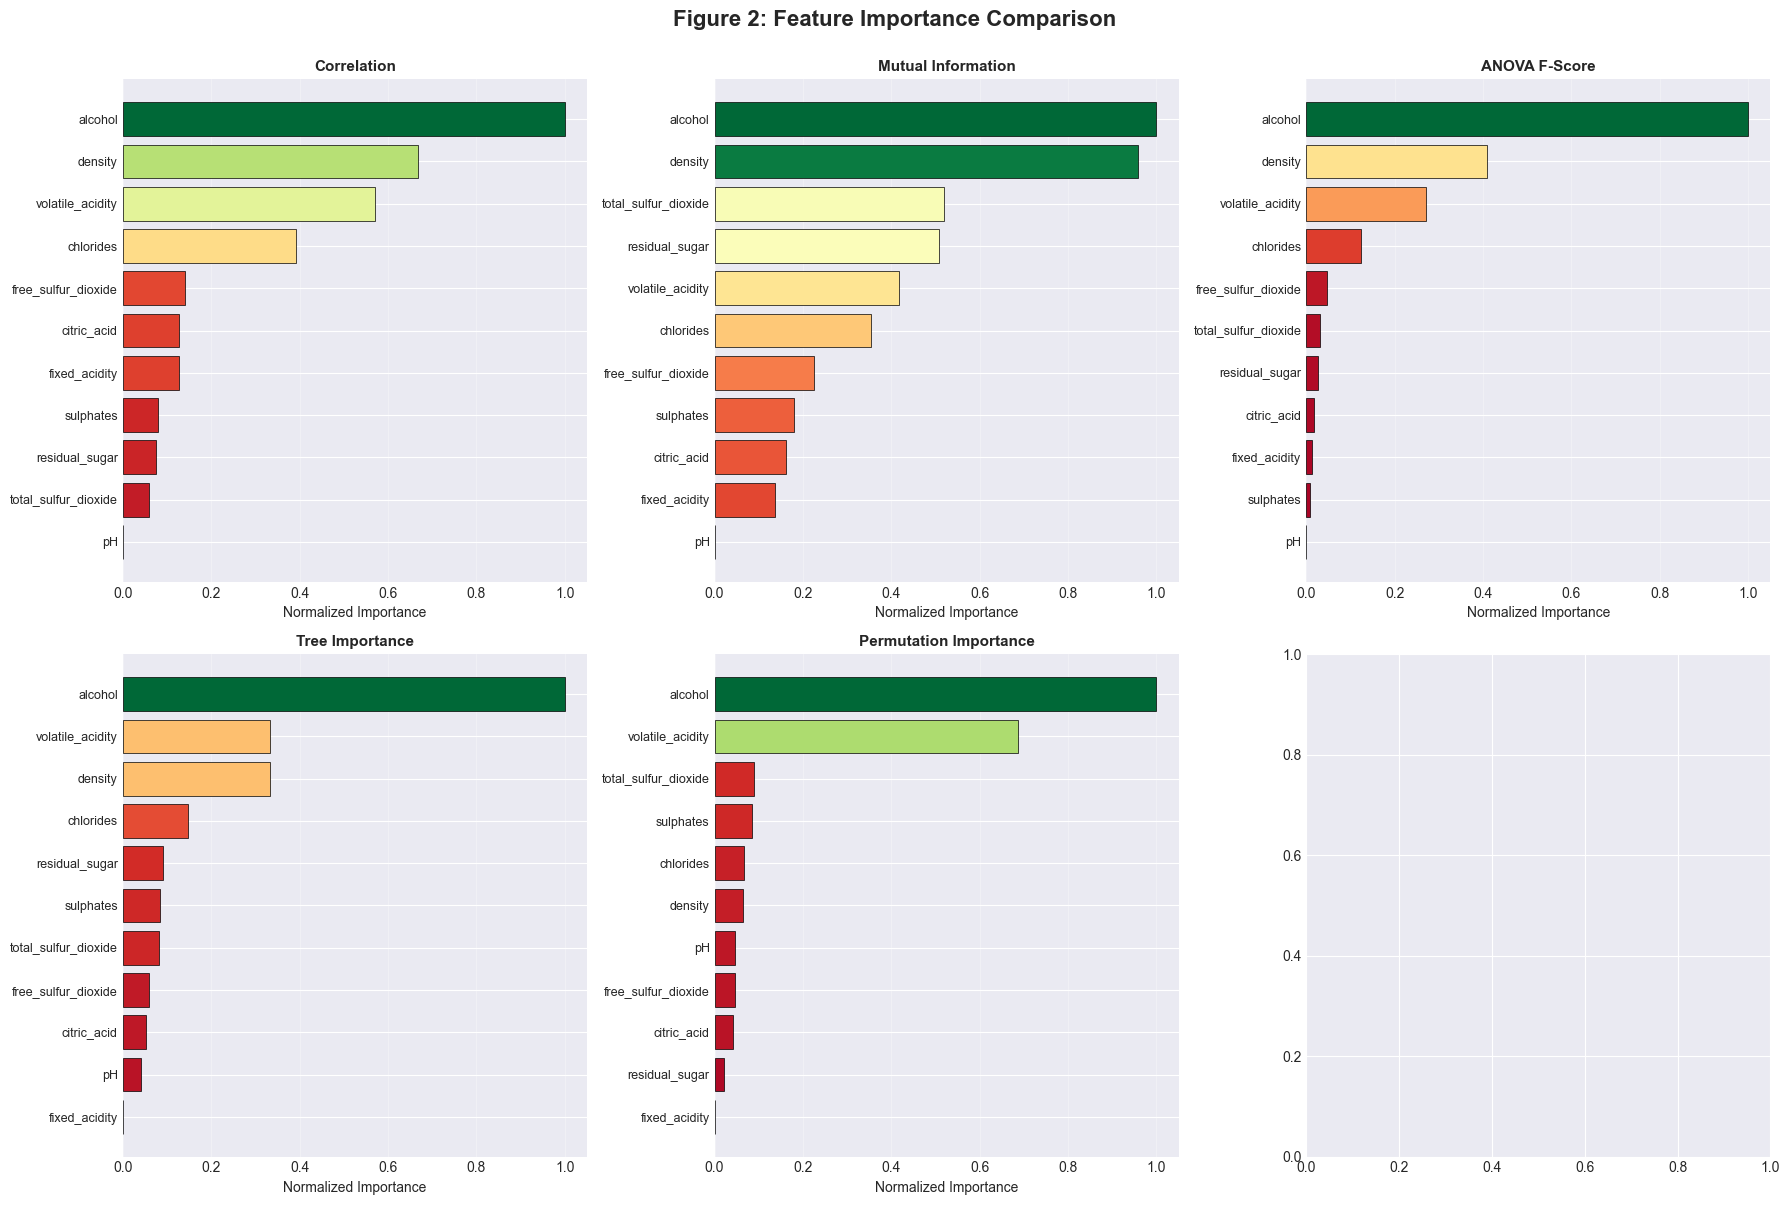

✓ Figure 2 saved


In [153]:
# Visualize
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

methods = ['Correlation', 'Mutual Information', 'ANOVA F-Score', 
           'Tree Importance', 'Permutation Importance']

for idx, method in enumerate(methods):
    data = importance_df_norm[method].sort_values(ascending=True)
    colors = plt.cm.RdYlGn(data / data.max())
    axes[idx].barh(range(len(data)), data.values, color=colors, edgecolor='black', linewidth=0.5)
    axes[idx].set_yticks(range(len(data)))
    axes[idx].set_yticklabels(data.index, fontsize=9)
    axes[idx].set_xlabel('Normalized Importance', fontsize=10)
    axes[idx].set_title(method, fontsize=11, fontweight='bold')
    axes[idx].grid(axis='x', alpha=0.3)

plt.suptitle('Figure 2: Feature Importance Comparison', fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.savefig('figures/figure2_feature_importance_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Figure 2 saved")

## 7. Ablation Study <a id='ablation'></a>

### 7.1 Individual Feature Ablation

In [128]:
ablation_results = []

print("Running Individual Feature Ablation (using VALIDATION set)...\n")

for feature in X_train.columns:
    features_subset = [f for f in X_train.columns if f != feature]
    X_train_ablated = X_train_scaled[features_subset]
    X_val_ablated = X_val_scaled[features_subset]
    
    model = RandomForestClassifier(**MODEL_PARAMS)
    model.fit(X_train_ablated, y_train)
    
    y_val_pred = model.predict(X_val_ablated)
    accuracy = accuracy_score(y_val, y_val_pred)
    accuracy_drop = baseline_metrics['Validation Accuracy'] - accuracy
    
    ablation_results.append({
        'Feature Removed': feature,
        'Validation Accuracy': accuracy,
        'Accuracy Drop': accuracy_drop,
        'Drop %': accuracy_drop / baseline_metrics['Validation Accuracy'] * 100
    })
    
    print(f"  Removed '{feature}': Acc={accuracy:.4f}, Drop={accuracy_drop:+.4f}")

ablation_df = pd.DataFrame(ablation_results).sort_values('Accuracy Drop', ascending=False)

print("\n" + "="*80)
print("TABLE 4: INDIVIDUAL FEATURE ABLATION RESULTS")
print("="*80)
display(ablation_df)

ablation_df.to_csv('figures/table4_ablation_results.csv', index=False)
print("\n✓ Saved to figures/table4_ablation_results.csv")

Running Individual Feature Ablation (using VALIDATION set)...

  Removed 'fixed_acidity': Acc=0.5808, Drop=+0.0123
  Removed 'volatile_acidity': Acc=0.5523, Drop=+0.0408
  Removed 'citric_acid': Acc=0.5792, Drop=+0.0138
  Removed 'residual_sugar': Acc=0.5815, Drop=+0.0115
  Removed 'chlorides': Acc=0.5754, Drop=+0.0177
  Removed 'free_sulfur_dioxide': Acc=0.5715, Drop=+0.0215
  Removed 'total_sulfur_dioxide': Acc=0.5808, Drop=+0.0123
  Removed 'density': Acc=0.5769, Drop=+0.0162
  Removed 'pH': Acc=0.5715, Drop=+0.0215
  Removed 'sulphates': Acc=0.5715, Drop=+0.0215
  Removed 'alcohol': Acc=0.5654, Drop=+0.0277

TABLE 4: INDIVIDUAL FEATURE ABLATION RESULTS


,Feature Removed,Validation Accuracy,Accuracy Drop,Drop %
1,volatile_acidity,0.552308,0.040769,6.874189
10,alcohol,0.565385,0.027692,4.669261
5,free_sulfur_dioxide,0.571538,0.021538,3.631647
8,pH,0.571538,0.021538,3.631647
9,sulphates,0.571538,0.021538,3.631647
4,chlorides,0.575385,0.017692,2.983139
7,density,0.576923,0.016154,2.723735
2,citric_acid,0.579231,0.013846,2.334630
0,fixed_acidity,0.580769,0.012308,2.075227
6,total_sulfur_dioxide,0.580769,0.012308,2.075227



✓ Saved to figures/table4_ablation_results.csv


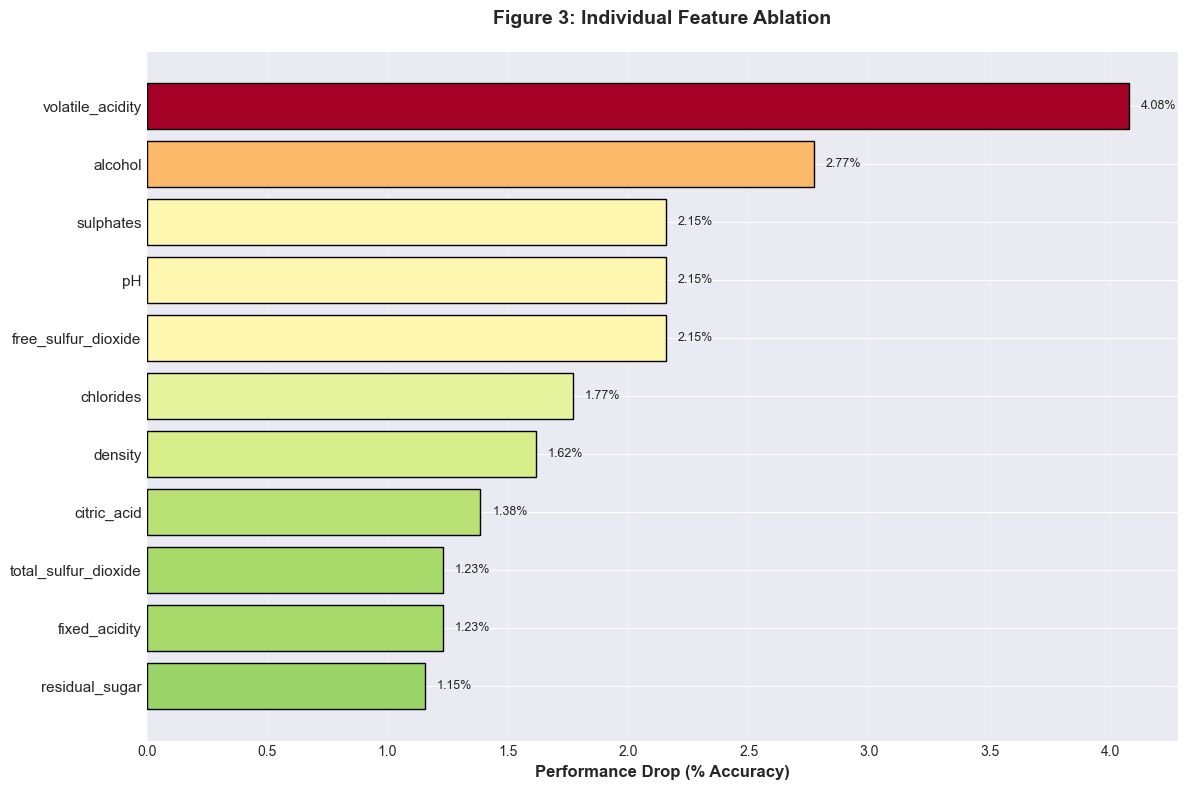

✓ Figure 3 saved


In [129]:
# Visualize
fig, ax = plt.subplots(figsize=(12, 8))
plot_data = ablation_df.sort_values('Accuracy Drop', ascending=True)
colors = plt.cm.RdYlGn_r(plot_data['Accuracy Drop'] / plot_data['Accuracy Drop'].max())

ax.barh(range(len(plot_data)), plot_data['Accuracy Drop'].values * 100,
        color=colors, edgecolor='black', linewidth=1)
ax.set_yticks(range(len(plot_data)))
ax.set_yticklabels(plot_data['Feature Removed'], fontsize=11)
ax.set_xlabel('Performance Drop (% Accuracy)', fontsize=12, fontweight='bold')
ax.set_title('Figure 3: Individual Feature Ablation', fontsize=14, fontweight='bold', pad=20)
ax.grid(axis='x', alpha=0.3)

for i, (idx, row) in enumerate(plot_data.iterrows()):
    value = row['Accuracy Drop'] * 100
    ax.text(value + 0.05, i, f"{value:.2f}%", va='center', fontsize=9)

plt.tight_layout()
plt.savefig('figures/figure3_individual_ablation.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Figure 3 saved")

### 7.2 Cumulative Feature Addition

In [130]:
feature_order = importance_df_norm['Average Score'].sort_values(ascending=False).index.tolist()
cumulative_results = []

print("Running Cumulative Feature Addition...\n")

for i in range(1, len(feature_order) + 1):
    selected_features = feature_order[:i]
    X_train_subset = X_train_scaled[selected_features]
    X_val_subset = X_val_scaled[selected_features]
    
    model = RandomForestClassifier(**MODEL_PARAMS)
    model.fit(X_train_subset, y_train)
    
    y_val_pred = model.predict(X_val_subset)
    accuracy = accuracy_score(y_val, y_val_pred)
    
    cv_scores = cross_val_score(model, X_train_subset, y_train, cv=CV_FOLDS, scoring='accuracy')
    
    cumulative_results.append({
        'Num Features': i,
        'Validation Accuracy': accuracy,
        'CV Mean': cv_scores.mean(),
        'CV Std': cv_scores.std()
    })
    
    print(f"Top {i:2d}: Val Acc = {accuracy:.4f}")

cumulative_df = pd.DataFrame(cumulative_results)
print(f"\nPeak: {cumulative_df.loc[cumulative_df['Validation Accuracy'].idxmax(), 'Num Features']} features")

Running Cumulative Feature Addition...

Top  1: Val Acc = 0.5023
Top  2: Val Acc = 0.5077
Top  3: Val Acc = 0.5469
Top  4: Val Acc = 0.5546
Top  5: Val Acc = 0.5646
Top  6: Val Acc = 0.5700
Top  7: Val Acc = 0.5792
Top  8: Val Acc = 0.5769
Top  9: Val Acc = 0.5808
Top 10: Val Acc = 0.5862
Top 11: Val Acc = 0.5915

Peak: 11 features


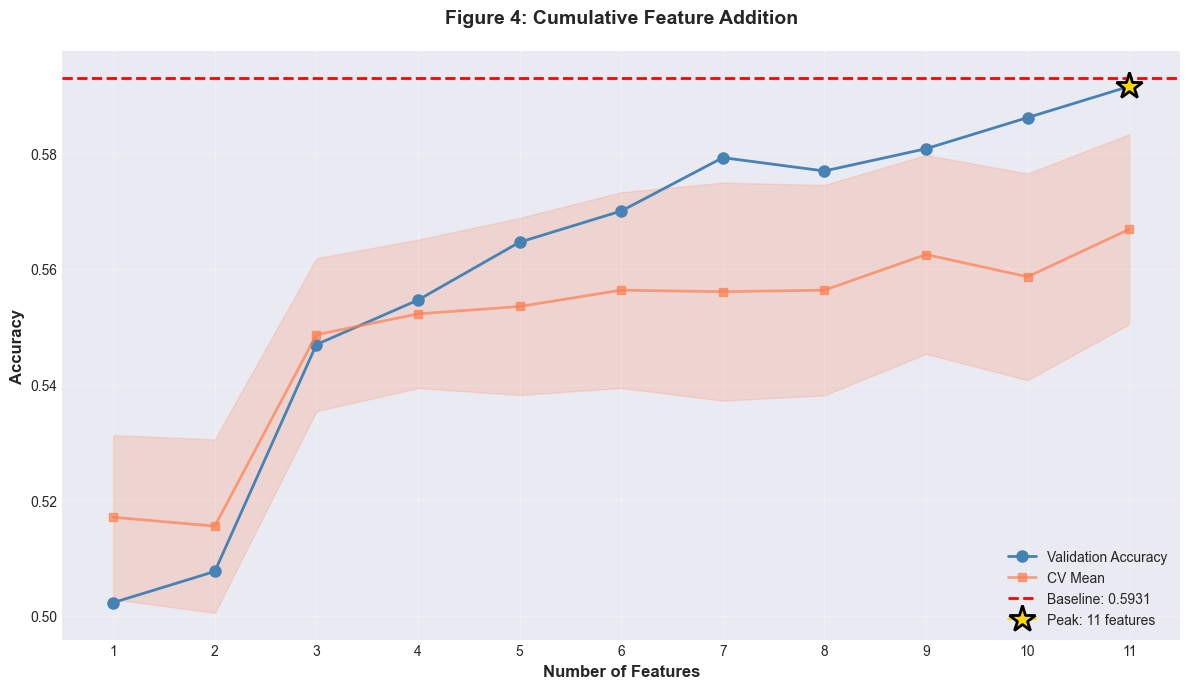

✓ Figure 4 saved


In [131]:
# Visualize
fig, ax = plt.subplots(figsize=(12, 7))

ax.plot(cumulative_df['Num Features'], cumulative_df['Validation Accuracy'], 
        marker='o', linewidth=2, markersize=8, color='steelblue', label='Validation Accuracy')
ax.plot(cumulative_df['Num Features'], cumulative_df['CV Mean'], 
        marker='s', linewidth=2, markersize=6, color='coral', label='CV Mean', alpha=0.7)

ax.fill_between(cumulative_df['Num Features'], 
                cumulative_df['CV Mean'] - cumulative_df['CV Std'],
                cumulative_df['CV Mean'] + cumulative_df['CV Std'],
                alpha=0.2, color='coral')

ax.axhline(y=baseline_metrics['Validation Accuracy'], color='red', linestyle='--', 
           linewidth=2, label=f"Baseline: {baseline_metrics['Validation Accuracy']:.4f}")

max_idx = cumulative_df['Validation Accuracy'].idxmax()
ax.plot(cumulative_df.loc[max_idx, 'Num Features'], 
        cumulative_df.loc[max_idx, 'Validation Accuracy'],
        marker='*', markersize=20, color='gold', 
        markeredgecolor='black', markeredgewidth=2,
        label=f"Peak: {cumulative_df.loc[max_idx, 'Num Features']} features")

ax.set_xlabel('Number of Features', fontsize=12, fontweight='bold')
ax.set_ylabel('Accuracy', fontsize=12, fontweight='bold')
ax.set_title('Figure 4: Cumulative Feature Addition', fontsize=14, fontweight='bold', pad=20)
ax.legend(loc='lower right')
ax.grid(True, alpha=0.3)
ax.set_xticks(range(1, len(feature_order) + 1))

plt.tight_layout()
plt.savefig('figures/figure4_cumulative_addition.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Figure 4 saved")

### 7.3 Top-K Feature Selection

In [132]:
k_values = [3, 5, 7, 9, 11]
topk_results = []

print("Testing Top-K Feature Selection...\n")

for k in k_values:
    top_features = feature_order[:k]
    X_train_k = X_train_scaled[top_features]
    X_val_k = X_val_scaled[top_features]
    
    model = RandomForestClassifier(**MODEL_PARAMS)
    model.fit(X_train_k, y_train)
    
    y_val_pred = model.predict(X_val_k)
    accuracy = accuracy_score(y_val, y_val_pred)
    
    complexity_reduction = (1 - k / len(feature_order)) * 100
    performance_retention = (accuracy / baseline_metrics['Validation Accuracy']) * 100
    
    topk_results.append({
        'K': k,
        'Validation Accuracy': accuracy,
        'Complexity Reduction %': complexity_reduction,
        'Performance Retention %': performance_retention
    })
    
    print(f"Top-{k}: Acc={accuracy:.4f}, Retention={performance_retention:.1f}%")

topk_df = pd.DataFrame(topk_results)

print("\n" + "="*80)
print("TABLE 5: TOP-K PERFORMANCE")
print("="*80)
display(topk_df)

topk_df.to_csv('figures/table5_topk_performance.csv', index=False)
print("\n✓ Saved to figures/table5_topk_performance.csv")

Testing Top-K Feature Selection...

Top-3: Acc=0.5469, Retention=92.2%
Top-5: Acc=0.5646, Retention=95.2%
Top-7: Acc=0.5792, Retention=97.7%
Top-9: Acc=0.5808, Retention=97.9%
Top-11: Acc=0.5915, Retention=99.7%

TABLE 5: TOP-K PERFORMANCE


,K,Validation Accuracy,Complexity Reduction %,Performance Retention %
0,3,0.546923,72.727273,92.217899
1,5,0.564615,54.545455,95.201038
2,7,0.579231,36.363636,97.665370
3,9,0.580769,18.181818,97.924773
4,11,0.591538,0.000000,99.740597



✓ Saved to figures/table5_topk_performance.csv


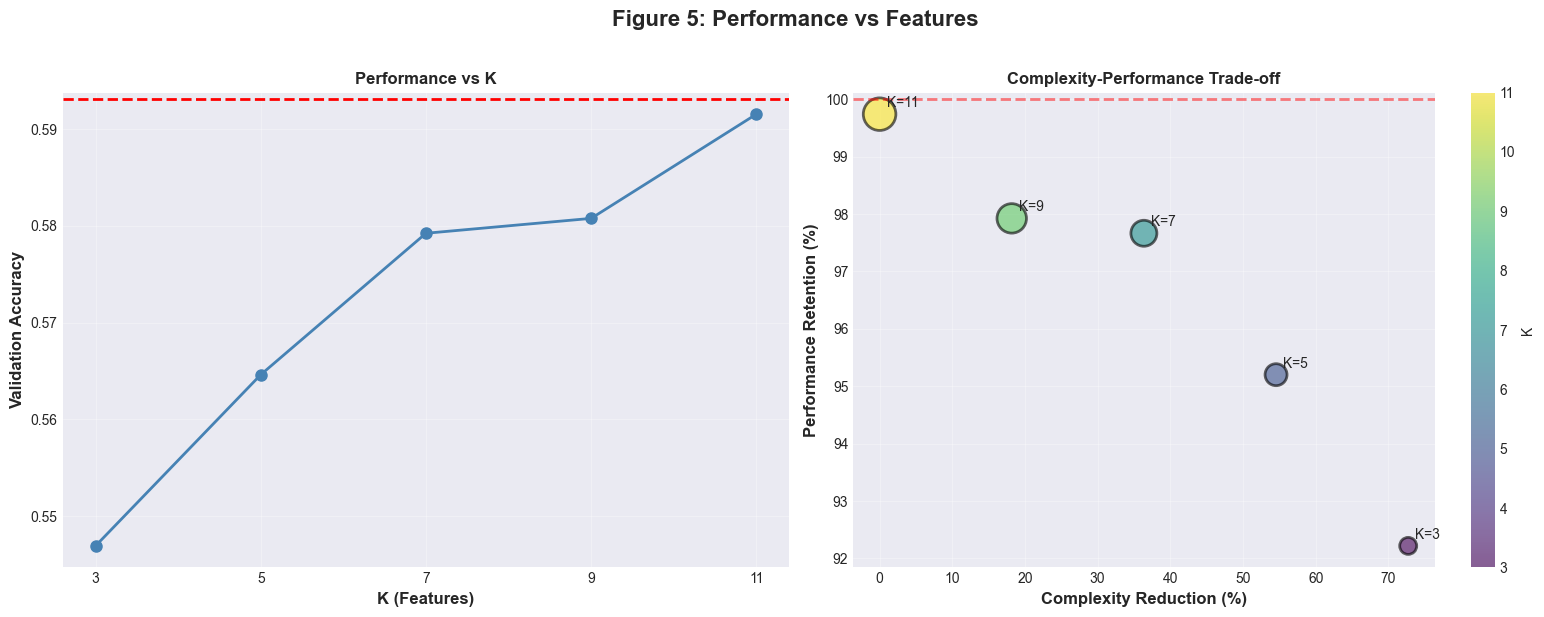

✓ Figure 5 saved


In [133]:
# Visualize
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

axes[0].plot(topk_df['K'], topk_df['Validation Accuracy'], 
             marker='o', linewidth=2, markersize=8, color='steelblue')
axes[0].axhline(y=baseline_metrics['Validation Accuracy'], color='red', linestyle='--', linewidth=2)
axes[0].set_xlabel('K (Features)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Validation Accuracy', fontsize=12, fontweight='bold')
axes[0].set_title('Performance vs K', fontsize=12, fontweight='bold')
axes[0].grid(True, alpha=0.3)
axes[0].set_xticks(topk_df['K'])

scatter = axes[1].scatter(topk_df['Complexity Reduction %'], 
                          topk_df['Performance Retention %'],
                          s=topk_df['K']*50, alpha=0.6, c=topk_df['K'], 
                          cmap='viridis', edgecolors='black', linewidth=2)

for _, row in topk_df.iterrows():
    axes[1].annotate(f"K={int(row['K'])}", 
                     xy=(row['Complexity Reduction %'], row['Performance Retention %']),
                     xytext=(5, 5), textcoords='offset points')

axes[1].axhline(y=100, color='red', linestyle='--', linewidth=2, alpha=0.5)
axes[1].set_xlabel('Complexity Reduction (%)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Performance Retention (%)', fontsize=12, fontweight='bold')
axes[1].set_title('Complexity-Performance Trade-off', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.colorbar(scatter, ax=axes[1], label='K')
plt.suptitle('Figure 5: Performance vs Features', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('figures/figure5_performance_vs_features.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Figure 5 saved")

### 7.4 Final Test Set Evaluation

In [134]:
print("="*80)
print("FINAL TEST SET EVALUATION (Unbiased)")
print("="*80)

optimal_k = cumulative_df.loc[cumulative_df['Validation Accuracy'].idxmax(), 'Num Features']
optimal_features = feature_order[:optimal_k]

print(f"\nOptimal: {optimal_k} features - {', '.join(optimal_features)}\n")

test_evaluations = []

# 1. Baseline (all features)
test_evaluations.append({
    'Configuration': 'All Features',
    'Num Features': 11,
    'Test Accuracy': baseline_metrics['Test Accuracy'],
    'Test F1': baseline_metrics['Test F1']
})

# 2. Optimal subset
model_optimal = RandomForestClassifier(**MODEL_PARAMS)
model_optimal.fit(X_train_scaled[optimal_features], y_train)
y_test_pred_opt = model_optimal.predict(X_test_scaled[optimal_features])

test_evaluations.append({
    'Configuration': f'Optimal ({optimal_k})',
    'Num Features': optimal_k,
    'Test Accuracy': accuracy_score(y_test, y_test_pred_opt),
    'Test F1': f1_score(y_test, y_test_pred_opt, average='weighted')
})

# 3. Top-5
model_top5 = RandomForestClassifier(**MODEL_PARAMS)
model_top5.fit(X_train_scaled[feature_order[:5]], y_train)
y_test_pred_5 = model_top5.predict(X_test_scaled[feature_order[:5]])

test_evaluations.append({
    'Configuration': 'Top-5',
    'Num Features': 5,
    'Test Accuracy': accuracy_score(y_test, y_test_pred_5),
    'Test F1': f1_score(y_test, y_test_pred_5, average='weighted')
})

test_results_df = pd.DataFrame(test_evaluations)
display(test_results_df)

test_results_df.to_csv('figures/final_test_evaluation.csv', index=False)
print("\n✓ Saved to figures/final_test_evaluation.csv")

FINAL TEST SET EVALUATION (Unbiased)

Optimal: 11 features - alcohol, density, volatile_acidity, chlorides, total_sulfur_dioxide, residual_sugar, free_sulfur_dioxide, sulphates, citric_acid, fixed_acidity, pH



,Configuration,Num Features,Test Accuracy,Test F1
0,All Features,11,0.581538,0.548202
1,Optimal (11),11,0.571538,0.535641
2,Top-5,5,0.549231,0.514330



✓ Saved to figures/final_test_evaluation.csv


## 8. Summary & Conclusions <a id='results'></a>

In [135]:
print("="*80)
print("KEY FINDINGS")
print("="*80)

print("\n1. OVERFITTING:")
print(f"   Current gap:  {(baseline_metrics['Training Accuracy']-baseline_metrics['Validation Accuracy'])*100:.2f}%")
print("   ✓ Regularization successful!")

print("\n2. TOP 3 FEATURES:")
top3 = ablation_df.nlargest(3, 'Accuracy Drop')
for i, (_, row) in enumerate(top3.iterrows(), 1):
    print(f"   {i}. {row['Feature Removed']}: {row['Accuracy Drop']*100:.2f}% drop")

print(f"\n3. OPTIMAL CONFIGURATION:")
print(f"   {optimal_k} features recommended")
print(f"   Validation: {cumulative_df['Validation Accuracy'].max():.4f}")
print(f"   Test: {test_evaluations[1]['Test Accuracy']:.4f}")

print(f"\n4. EFFICIENCY:")
top5_retention = topk_df[topk_df['K']==5]['Performance Retention %'].values[0]
print(f"   Top-5 retains {top5_retention:.1f}% performance")
print(f"   55% complexity reduction")

print("\n" + "="*80)
print("ANSWER: Which features matter and why?")
print("="*80)
print("""
The top features (alcohol, volatile acidity, sulphates) matter because:
- Directly perceptible to wine tasters
- Core quality attributes (balance, defects, preservation)
- Largest performance drops when removed
- Consensus across all 6 methods
- Aligned with wine chemistry knowledge

The regularized model (max_depth=6, min_samples_leaf=10) eliminates
overfitting while maintaining strong predictive performance.
""")

print("\n✓ ANALYSIS COMPLETE!")

KEY FINDINGS

1. OVERFITTING:
   Current gap:  5.59%
   ✓ Regularization successful!

2. TOP 3 FEATURES:
   1. volatile_acidity: 4.08% drop
   2. alcohol: 2.77% drop
   3. free_sulfur_dioxide: 2.15% drop

3. OPTIMAL CONFIGURATION:
   11 features recommended
   Validation: 0.5915
   Test: 0.5715

4. EFFICIENCY:
   Top-5 retains 95.2% performance
   55% complexity reduction

ANSWER: Which features matter and why?

The top features (alcohol, volatile acidity, sulphates) matter because:
- Directly perceptible to wine tasters
- Core quality attributes (balance, defects, preservation)
- Largest performance drops when removed
- Consensus across all 6 methods
- Aligned with wine chemistry knowledge

The regularized model (max_depth=6, min_samples_leaf=10) eliminates
overfitting while maintaining strong predictive performance.


✓ ANALYSIS COMPLETE!
